In [1]:
from tqdm.notebook import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import copy

import torch
import torch.optim as optim
import torch.nn as nn

# Bayes by backprop models
from models.regression import BayesianRegressor, BayesianRegressorHeteroscedastic
# Baselines
from models.baselines import BaselineLinearRegressor, BaselineLinRegressorWithDropout
from utils.experiments import experiment
from utils.vis import visualize_training, weights_histogram, visualize_inference, visualize_deterministic, deterministic_histogram
from utils.predictive import mean_var_predictive, ensembles_inference

plt.style.use('seaborn-white')

Defining device

In [2]:
# Defining device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Defining training and test data

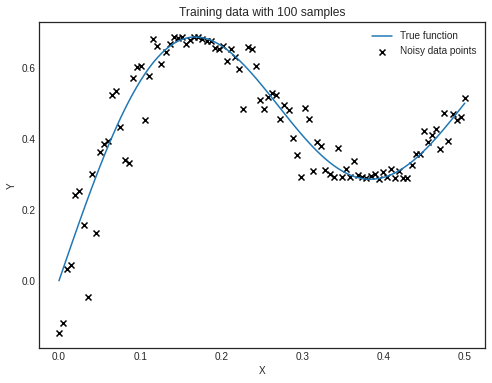

In [3]:
# Settings seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# toy dataset we can start with
train_samples = 100
# Training samples
X_train, y_train = experiment(xmin = 0, xmax = 0.5, samples = train_samples, std = 0.02)
_, y_train_true = experiment(xmin = 0, xmax = 0.5, samples = train_samples, std = 0)
# Test samples (from -0.3 to 1.0)
test_samples = 100
exp_samples = 50
X_test, y_test = experiment(xmin = -0.2, xmax = 1.2, samples = test_samples, std = 0.02)
_, y_test_true = experiment(xmin = -0.2, xmax = 1.2, samples = test_samples, std = 0)

# Visualizing data sample
fig1 = visualize_training(X_train.numpy(), y_train.numpy(), y_train_true.numpy())
fig1.savefig('assets/training.png')

Evaluating over all the possible priors with 5 ELBO samples and different mixture parameters

# --------------------------
# ------------- Training Normal -------------
# --------------------------


  0%|          | 0/3000 [00:00<?, ?it/s]

# --------------------------
# ------------- Finished Training Normal -------------
# ------------- Evaluation Normal -------------
# --------------------------


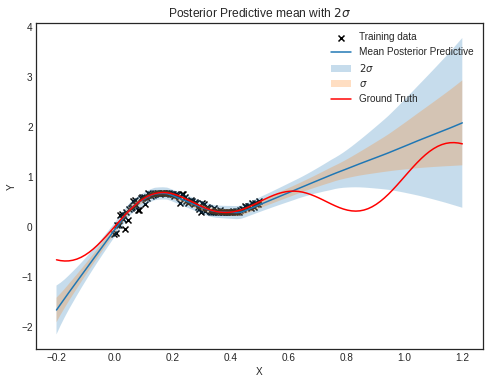

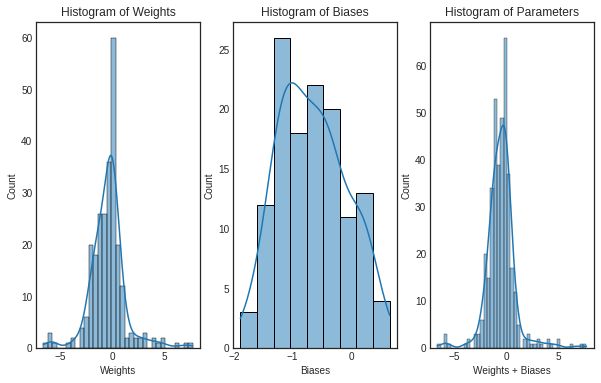

# --------------------------
# ------------- Training Mixture1 -------------
# --------------------------


  0%|          | 0/3000 [00:00<?, ?it/s]

# --------------------------
# ------------- Finished Training Mixture1 -------------
# ------------- Evaluation Mixture1 -------------
# --------------------------


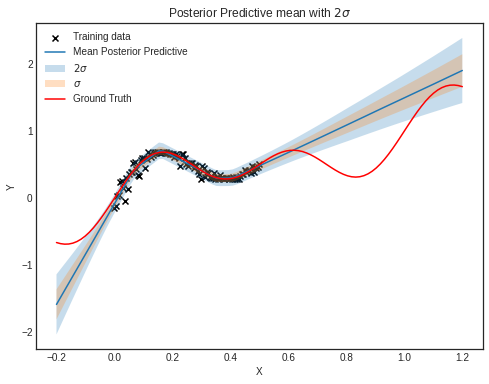

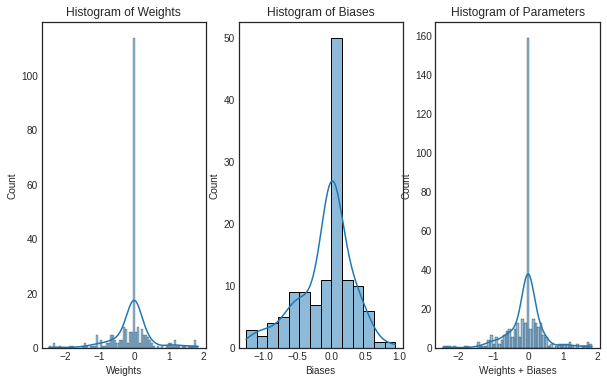

# --------------------------
# ------------- Training Mixture2 -------------
# --------------------------


  0%|          | 0/3000 [00:00<?, ?it/s]

# --------------------------
# ------------- Finished Training Mixture2 -------------
# ------------- Evaluation Mixture2 -------------
# --------------------------


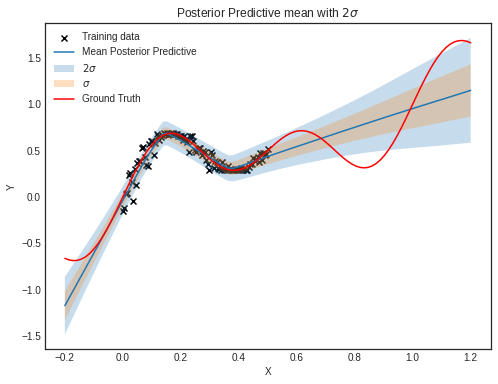

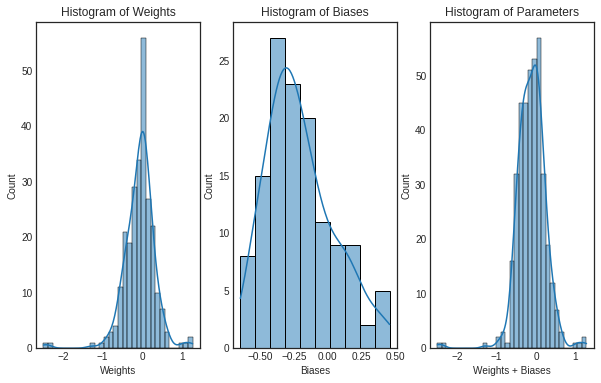

# --------------------------
# ------------- Training Mixture3 -------------
# --------------------------


  0%|          | 0/3000 [00:00<?, ?it/s]

# --------------------------
# ------------- Finished Training Mixture3 -------------
# ------------- Evaluation Mixture3 -------------
# --------------------------


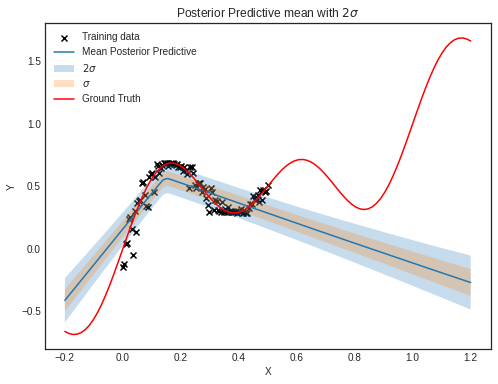

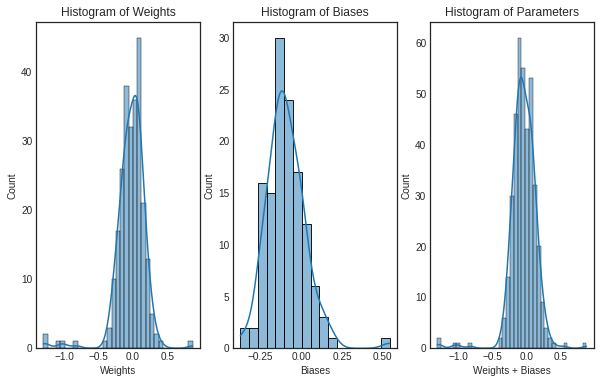

In [4]:
# Experiment params -log\sigma_1, -log\sigma_2, pi, mixture
experiments_prior = {'Normal': (0, 6, 1 / 4, False), 'Mixture1': (0, 6, 1 / 4, True),
               'Mixture2': (1, 7, 1 / 2, True), 'Mixture3': (2, 8, 3 / 4, True)}

# Defining params
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
epochs = 3000
elbo_samples = 5
mse = nn.MSELoss()
# Likelihood variance
ll_var = 0.05**2 # In the paper they always work with the stdv!
# Relevant data
training_losses = torch.zeros(len(experiments_prior), epochs)
mean_predictive = torch.zeros(len(experiments_prior), test_samples)
var_predictive = torch.zeros(len(experiments_prior), test_samples)
mse_error = torch.zeros(len(experiments_prior))
mean_std = torch.zeros(len(experiments_prior))

for idx, (exp, params) in enumerate(experiments_prior.items()):
    # Likelihood variance
    model = BayesianRegressor(hidden_dim=128, ll_var=ll_var, mixture_params = params[:3],
                              mixture_prior = params[-1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    print('# --------------------------')
    print('# ------------- Training {} -------------'.format(exp))
    print('# --------------------------')
    for epoch in tqdm_notebook(range(epochs)):  # loop over the dataset multiple times
        optimizer.zero_grad()
        # forward + backward + optimize
        loss = model.energy_loss(X_train, y_train, elbo_samples)
        loss.backward()
        optimizer.step()

        # Store training losses
        training_losses[idx, epoch] = loss.item()

    print('# --------------------------')
    print('# ------------- Finished Training {} -------------'.format(exp))
    print('# ------------- Evaluation {} -------------'.format(exp))
    print('# --------------------------')
    y_samp = np.zeros((exp_samples, test_samples))
    # Testing experiment
    for s in range(exp_samples):
        y_hat = model.forward(X_test).cpu().detach().numpy()
        # Storing results
        y_samp[s, :] = y_hat.reshape(-1)
    # Computing mean and variance of predictive distribution
    predictive_mean, predictive_var = mean_var_predictive(y_samp, np.array(ll_var))
    mean_predictive[idx, :] = torch.from_numpy(predictive_mean)
    var_predictive[idx, :] = torch.from_numpy(predictive_var)
    # Save result
    fig_eval = visualize_inference(X_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(),
                            X_test.cpu().detach().numpy(), y_test_true.cpu().detach().numpy(),
                            predictive_mean, predictive_var)
    fig_eval.savefig('assets/priors/{}_res.png'.format(exp))
    # Histogram of weights
    _, _, fig_hist = weights_histogram(model)
    fig_hist.savefig('assets/priors/{}_hist.png'.format(exp))
    # Evaluating against true value
    error = mse(torch.from_numpy(predictive_mean), torch.squeeze(y_test_true))
    mse_error[idx] = error
    # Computing mean stdv in training data regime
    y_samp = np.zeros((exp_samples, train_samples))
    for s in range(exp_samples):
        y_hat = model.forward(X_train).cpu().detach().numpy()
        # Storing results
        y_samp[s, :] = y_hat.reshape(-1)
    predictive_mean, predictive_var = mean_var_predictive(y_samp, np.array(ll_var))
    avg_std = torch.sqrt(torch.mean(torch.from_numpy(predictive_var)))
    mean_std[idx] = avg_std

Visualizing and comparing loss curves and results

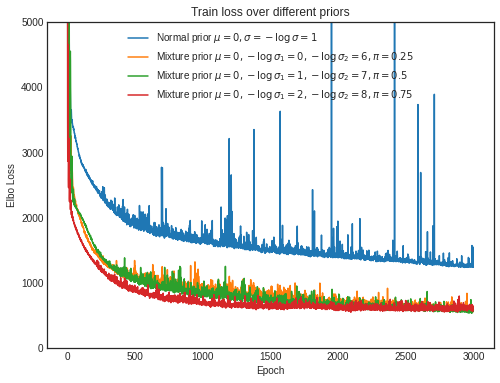

In [5]:
fig_loss = plt.figure(figsize=(8, 6))
plt.plot(training_losses[0, :], label='Normal prior $\mu = 0, \sigma = - \log \sigma = 1$')
plt.plot(training_losses[1, :], label='Mixture prior $\mu = 0, - \log \sigma_1 = 0, - '
                                      '\log \sigma_2 = 6, \pi = 0.25$')
plt.plot(training_losses[2, :], label='Mixture prior $\mu = 0, - \log \sigma_1 = 1, - '
                                      '\log \sigma_2 = 7, \pi = 0.5$')
plt.plot(training_losses[3, :], label='Mixture prior $\mu = 0, - \log \sigma_1 = 2, - '
                                      '\log \sigma_2 = 8, \pi = 0.75$')
plt.title('Train loss over different priors')
plt.xlabel("Epoch")
plt.ylabel("Elbo Loss")
plt.ylim([0, 5000])
plt.legend()
plt.show()
fig_loss.savefig('assets/priors/loss_curves.png')

In [6]:
for idx, exp in enumerate(experiments_prior.keys()):
    print('The MSE error in the test set for {} was: {}'.format(exp, mse_error[idx]))
    print('The avg stdv in the train regime for {} was: {}'.format(exp, mean_std[idx]))

# Finally, save results for future use
np.savetxt('assets/priors/data/loss.txt', training_losses.cpu().detach().numpy(), delimiter=',')
np.savetxt('assets/priors/data/mean.txt', mean_predictive.cpu().detach().numpy(), delimiter=',')
np.savetxt('assets/priors/data/var.txt', var_predictive.cpu().detach().numpy(), delimiter=',')
np.savetxt('assets/priors/data/mse.txt', mse_error.cpu().detach().numpy(), delimiter=',')
np.savetxt('assets/priors/data/std.txt', mean_std.cpu().detach().numpy(), delimiter=',')


The MSE error in the test set for Normal was: 0.19239164888858795
The avg stdv in the train regime for Normal was: 0.06283507496118546
The MSE error in the test set for Mixture1 was: 0.14820341765880585
The avg stdv in the train regime for Mixture1 was: 0.06313756108283997
The MSE error in the test set for Mixture2 was: 0.06460366398096085
The avg stdv in the train regime for Mixture2 was: 0.06542054563760757
The MSE error in the test set for Mixture3 was: 0.5379769206047058
The avg stdv in the train regime for Mixture3 was: 0.06657545268535614


### Training and comparison with Baselines

Linear model and Naive Dropout

# --------------------------
# ------------- Training Linear -------------
# --------------------------


  0%|          | 0/3000 [00:00<?, ?it/s]

# --------------------------
# ------------- Finished Training Linear -------------
# ------------- Evaluation Linear -------------
# --------------------------


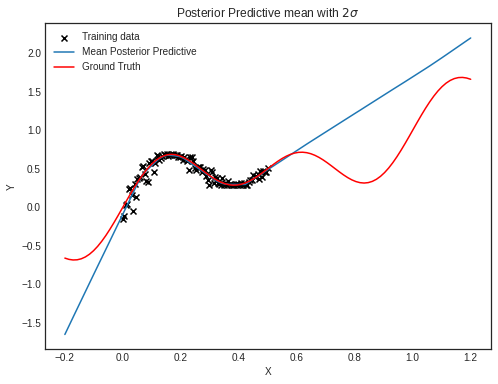

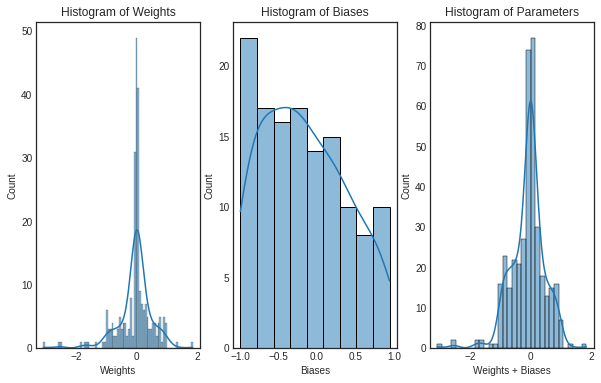

# --------------------------
# ------------- Training Dropout -------------
# --------------------------


  0%|          | 0/3000 [00:00<?, ?it/s]

# --------------------------
# ------------- Finished Training Dropout -------------
# ------------- Evaluation Dropout -------------
# --------------------------


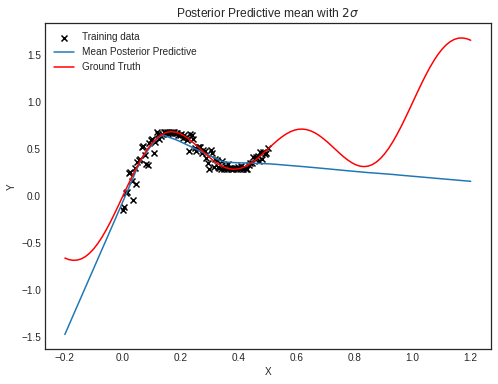

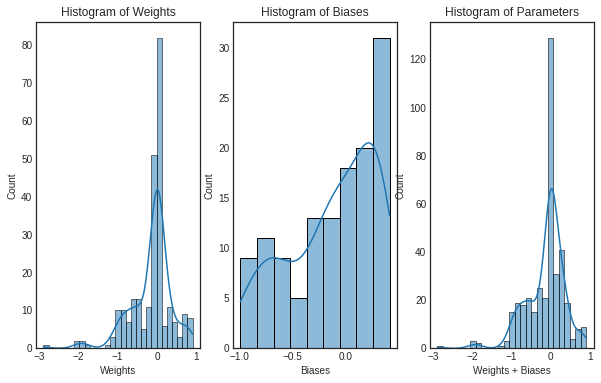

In [7]:
baselines_list = {0: 'Linear', 1: 'Dropout', 2: 'MCdropout', 3: 'Ensembles'}
modelL = BaselineLinearRegressor(hidden_dim=128).to(device)
modelD = BaselineLinRegressorWithDropout(hidden_dim=128, dropout_p=0.2).to(device)
# modelMC = BaselineLinRegressorWithDropout(hidden_dim=128, dropout_p=0.2).to(device)
epochs = 3000 # Same as with previous model

# Relevant data bd = Baseline deterministic
training_losses_b = torch.zeros(4, epochs)
mean_predictive_b = torch.zeros(4, test_samples)
var_predictive_b = torch.zeros(4, test_samples)
mse_error_b = torch.zeros(4)
mean_std_b = torch.zeros(4)

for idx, m in enumerate((modelL, modelD)):
    optimizer = optim.Adam(m.parameters(), lr=0.01)
    print('# --------------------------')
    print('# ------------- Training {} -------------'.format(baselines_list[idx]))
    print('# --------------------------')
    m.train()
    for epoch in tqdm_notebook(range(epochs)):  # loop over the dataset multiple times
        optimizer.zero_grad()
        # forward + backward + optimize
        y_hat = m(X_train)
        loss = mse(y_hat, y_train)
        loss.backward()
        optimizer.step()

        # Store training losses
        training_losses_b[idx, epoch] = loss.item()

    print('# --------------------------')
    print('# ------------- Finished Training {} -------------'.format(baselines_list[idx]))
    print('# ------------- Evaluation {} -------------'.format(baselines_list[idx]))
    print('# --------------------------')
    m.eval()
    # Testing experiment
    y_hat_test = m(X_test)
    mean_predictive_b[idx, :] = torch.squeeze(y_hat_test)
    error = mse(y_hat_test, y_test_true.to(device))
    mse_error_b[idx] = error
    # Save result
    fig_eval = visualize_deterministic(X_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(),
                                       X_test.cpu().detach().numpy(), y_test_true.cpu().detach().numpy(),
                                       y_hat_test.cpu().detach().numpy())
    fig_eval.savefig('assets/baselines/{}_res.png'.format(baselines_list[idx]))
    # Histogram of weights
    _, _, fig_hist = deterministic_histogram(m)
    fig_hist.savefig('assets/baselines/{}_hist.png'.format(baselines_list[idx]))

MC-Dropout

# --------------------------
# ------------- Training MCdropout -------------
# --------------------------


  0%|          | 0/3000 [00:00<?, ?it/s]

# --------------------------
# ------------- Finished Training MCdropout -------------
# ------------- Evaluation MCdropout -------------
# --------------------------


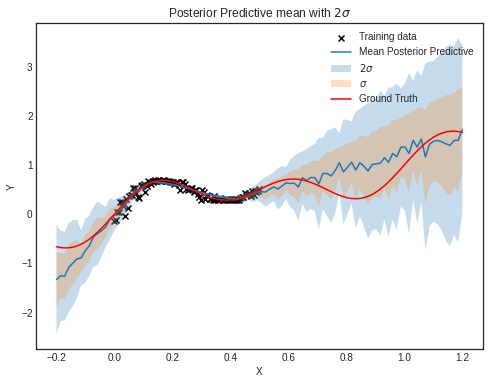

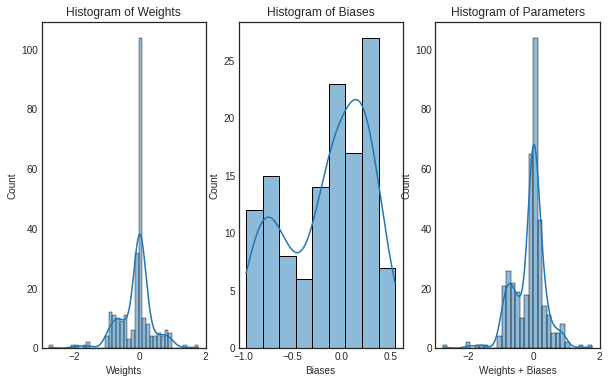

In [8]:
modelMC = BaselineLinRegressorWithDropout(hidden_dim=128, dropout_p=0.2).to(device)
optimizer = optim.Adam(modelMC.parameters(), lr=0.01)

# Set model for training
modelMC.train()
print('# --------------------------')
print('# ------------- Training {} -------------'.format(baselines_list[2]))
print('# --------------------------')
for epoch in tqdm_notebook(range(epochs)):  # loop over the dataset multiple times
    optimizer.zero_grad()
    # forward + backward + optimize
    y_hat = modelMC(X_train)
    loss = mse(y_hat, y_train)
    loss.backward()
    optimizer.step()

    # Store training losses
    training_losses_b[2, epoch] = loss.item()

print('# --------------------------')
print('# ------------- Finished Training {} -------------'.format(baselines_list[2]))
print('# ------------- Evaluation {} -------------'.format(baselines_list[2]))
print('# --------------------------')
# Testing
y_samp = torch.zeros((exp_samples, test_samples))
# Testing experiment
for s in range(exp_samples):
    y_hat = modelMC.forward(X_test)
    # Storing results
    y_samp[s, :] = y_hat.reshape(-1)

mean_predictive_b[2, :] = torch.mean(y_samp, dim=0)
var_predictive_b[2, :] = torch.var(y_samp, dim=0)
error = mse(mean_predictive_b[2, :], torch.squeeze(y_test_true))
mse_error_b[2] = error
# Save result
fig_eval = visualize_inference(X_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(),
                               X_test.cpu().detach().numpy(), y_test_true.cpu().detach().numpy(),
                               mean_predictive_b[2, :].cpu().detach().numpy(),
                               var_predictive_b[2, :].cpu().detach().numpy())
fig_eval.savefig('assets/baselines/{}_res.png'.format(baselines_list[2]))
# Histogram of weights
_, _, fig_hist = deterministic_histogram(modelMC)
fig_hist.savefig('assets/baselines/{}_hist.png'.format(baselines_list[2]))

# Computing mean stdv in training data regime
y_samp = torch.zeros((exp_samples, train_samples))
for s in range(exp_samples):
    y_hat = modelMC.forward(X_train)
    # Storing results
    y_samp[s, :] = y_hat.reshape(-1)
predictive_mean, predictive_var = torch.mean(y_samp, dim=0), torch.var(y_samp, dim=0)
avg_std = torch.sqrt(torch.mean(predictive_var))
mean_std_b[2] = avg_std

Training Ensembles

# --------------------------
# ------------- Training Ensembles -------------
# --------------------------


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

# --------------------------
# ------------- Finished Training Ensembles -------------
# ------------- Evaluation Ensembles -------------
# --------------------------


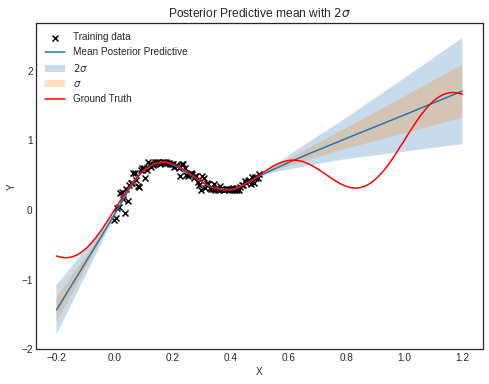

In [9]:
models = []
print('# --------------------------')
print('# ------------- Training {} -------------'.format(baselines_list[3]))
print('# --------------------------')
for _ in range(5):
    modelE = BaselineLinearRegressor(hidden_dim=128).to(device)
    optimizer = optim.Adam(modelE.parameters(), lr=0.01)
    for epoch in tqdm_notebook(range(epochs)):  # loop over the dataset multiple times
        optimizer.zero_grad()
        # forward + backward + optimize
        y_hat = modelE(X_train)
        loss = mse(y_hat, y_train)
        loss.backward()
        optimizer.step()

        # Store training losses - This loss needs to be averaged!
        training_losses_b[3, epoch] += loss.item()
    models.append(copy.deepcopy(modelE))
print('# --------------------------')
print('# ------------- Finished Training {} -------------'.format(baselines_list[3]))
print('# ------------- Evaluation {} -------------'.format(baselines_list[3]))
print('# --------------------------')
training_losses_b[3, :] = training_losses_b[3, :] / 5
# Testing
predictive_mean, predictive_var = ensembles_inference(models, X_test)

mean_predictive_b[3, :] = predictive_mean
var_predictive_b[3, :] = predictive_var
error = mse(predictive_mean, torch.squeeze(y_test_true))
mse_error_b[3] = error
# Save result
fig_eval = visualize_inference(X_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(),
                               X_test.cpu().detach().numpy(), y_test_true.cpu().detach().numpy(),
                               predictive_mean.cpu().detach().numpy(),
                               predictive_var.cpu().detach().numpy())
fig_eval.savefig('assets/baselines/{}_res.png'.format(baselines_list[3]))

# Computing mean stdv in training data regime
predictive_mean, predictive_var = ensembles_inference(models, X_train)
avg_std = torch.sqrt(torch.mean(predictive_var))
mean_std_b[3] = avg_std

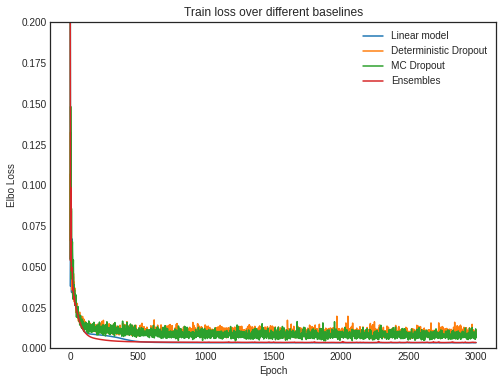

In [10]:
fig_loss = plt.figure(figsize=(8, 6))
plt.plot(training_losses_b[0, :], label='Linear model')
plt.plot(training_losses_b[1, :], label='Deterministic Dropout')
plt.plot(training_losses_b[2, :], label='MC Dropout')
plt.plot(training_losses_b[3, :], label='Ensembles')
plt.title('Train loss over different baselines')
plt.xlabel("Epoch")
plt.ylabel("Elbo Loss")
plt.ylim([0, 0.2])
plt.legend()
plt.show()

fig_loss.savefig('assets/baselines/loss_curves.png')

In [11]:
for idx, exp in enumerate(baselines_list.values()):
    print('The MSE error in the test set for {} was: {}'.format(exp, mse_error_b[idx]))
    print('The avg stdv in the train regime for {} was: {}'.format(exp, mean_std_b[idx]))

# # Finally, save results for future use
np.savetxt('assets/baselines/data/loss.txt', training_losses_b.cpu().detach().numpy(), delimiter=',')
np.savetxt('assets/baselines/data/mean.txt', mean_predictive_b.cpu().detach().numpy(), delimiter=',')
np.savetxt('assets/baselines/data/var.txt', var_predictive_b.cpu().detach().numpy(), delimiter=',')
np.savetxt('assets/baselines/data/mse.txt', mse_error_b.cpu().detach().numpy(), delimiter=',')
np.savetxt('assets/baselines/data/std.txt', mean_std_b.cpu().detach().numpy(), delimiter=',')

The MSE error in the test set for Linear was: 0.2278594970703125
The avg stdv in the train regime for Linear was: 0.0
The MSE error in the test set for Dropout was: 0.3168463110923767
The avg stdv in the train regime for Dropout was: 0.0
The MSE error in the test set for MCdropout was: 0.08054783940315247
The avg stdv in the train regime for MCdropout was: 0.05592646449804306
The MSE error in the test set for Ensembles was: 0.10835090279579163
The avg stdv in the train regime for Ensembles was: 0.008826842531561852


### Experiment with Heteroscedastic data

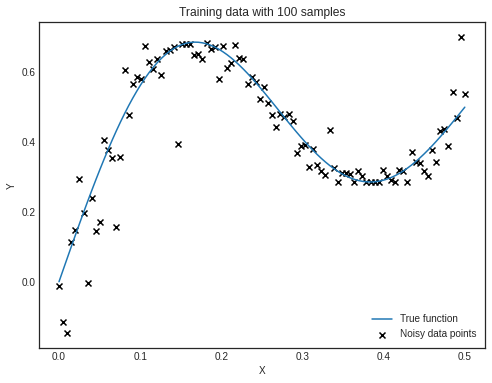

In [12]:
# toy dataset we can start with
train_samples = 100
# Training samples
X_train, y_train = experiment(xmin = 0, xmax = 0.5, samples = train_samples, std = 0.05, h = True)
_, y_train_true = experiment(xmin = 0, xmax = 0.5, samples = train_samples, std = 0)
# Test samples (from -0.3 to 1.0)
test_samples = 100
exp_samples = 50
X_test, y_test = experiment(xmin = -0.2, xmax = 1.2, samples = test_samples, std = 0.05, h = True)
_, y_test_true = experiment(xmin = -0.2, xmax = 1.2, samples = test_samples, std = 0)

# Visualizing data sample
fig1 = visualize_training(X_train.numpy(), y_train.numpy(), y_train_true.numpy())

In [ ]:
ll_var = 1.0 # 0.05**2 # In the paper they always work with the stdv!
# Using best model
model = BayesianRegressorHeteroscedastic(hidden_dim=128, ll_var=ll_var,
                                         mixture_prior=False, mixture_params=(0, 6, 1 / 4)).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
elbo_samples = 5
epochs = 5000

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

print('# --------------------------')
print('# -------- Training --------')
print('# --------------------------')
for epoch in tqdm_notebook(range(epochs)):  # loop over the dataset multiple times
    optimizer.zero_grad()
    # forward + backward + optimize
    if epoch > 1000: # Start variance estimation
        loss = model.energy_loss(X_train, y_train, elbo_samples, False)
    else:
        loss = model.energy_loss(X_train, y_train, elbo_samples, True)
    loss.backward()
    optimizer.step()

y_samp = np.zeros((exp_samples, test_samples))
var_samp = np.zeros((exp_samples, test_samples))
# Testing experiment
for s in range(exp_samples):
    y_hat = model.forward(X_test).cpu().detach().numpy()
    # Storing results
    y_samp[s, :] = y_hat[:,0].reshape(-1)
    # Exponentiate and recover variance
    var_samp[s, :] = np.exp(y_hat[:,1].reshape(-1))
# Computing mean and variance of predictive distribution
predictive_mean, predictive_var = mean_var_predictive(y_samp, var_samp)
# Save result
fig_eval = visualize_inference(X_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(),
                               X_test.cpu().detach().numpy(), y_test_true.cpu().detach().numpy(),
                               predictive_mean, predictive_var)
fig_eval.savefig('assets/heteroscedastic/{}_res.png'.format('Mixture1'))
# Histogram of weights
_, _, fig_hist = weights_histogram(model)
fig_hist.savefig('assets/heteroscedastic/{}_hist.png'.format('Mixture1'))
# Evaluating against true value
error = mse(torch.from_numpy(predictive_mean), torch.squeeze(y_test_true))
# Computing mean stdv in training data regime
y_samp = np.zeros((exp_samples, train_samples))
var_samp = np.zeros((exp_samples, test_samples))
for s in range(exp_samples):
    y_hat = model.forward(X_train).cpu().detach().numpy()
    # Storing results
    y_samp[s, :] = y_hat[:,0].reshape(-1)
    # Exponentiate and recover variance
    var_samp[s, :] = np.exp(y_hat[:,1].reshape(-1))
predictive_mean, predictive_var = mean_var_predictive(y_samp, var_samp)
avg_std = torch.sqrt(torch.mean(torch.from_numpy(predictive_var)))

print('The MSE error in the test set is {} and the avg stdv in the train set is: {}'.format(error, avg_std))


# --------------------------
# -------- Training --------
# --------------------------


  0%|          | 0/5000 [00:00<?, ?it/s]